# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from src import cellsim as cellsim 

%matplotlib widget
%load_ext autoreload

# CV Mode Equations

Current decay during CV mode is analytically solvable for the nRC case:

$$
I_{CV} = \frac{V_t - V_{OC} - \sum_n R_{1,n}I_{R_{1,n}}\exp{(-\frac{\Delta t}{\tau_n})}}{\sum_n(R_{0,n} + R_{1,n}(1-\exp{(-\frac{\Delta t}{\tau_n})}))}
$$

# SEI growth dynamics

SEI growth is modeled using the following approach.

The total applied current is distributed across intercalation and SEI

$$
I_{app} = I_{int} + I_{SEI}
$$

The SEI current is related to the current density by (Eqn. 1j from Sulzer2021):

$$
I_{SEI} = -a_sA_nL_n j_{SEI}
$$

where 
- $a_s$ is the specific surface area [1/m]
- $A_n$ is the negative electrode area [m^2] 
- $L_n$ is the negative electrode length [m] 
- $j_{SEI}$ is the SEI volumetric current density [A/m^3].

The mixed reaction and diffusion limited SEI current density is (Eqn. 16 from Sulzer2021):

$$
j_{SEI} = \frac{-c_{EC}^{bulk}}{1/(a_{sei}Fk_{SEI}\exp(-\alpha_{SEI}F\eta_{SEI}/RT)) + \delta_{SEI}/(D_{SEI}F)}
$$

Note that $j_{SEI} = f(\eta_{SEI}, \delta_{SEI})$. All the other terms in the equation are constants.

The SEI reaction overpotential $\eta_{SEI}$ is (Eqn. 1g from Sulzer2021):

$$
\eta_{SEI} = \phi_{s,n} - \phi_e - U_{SEI} - j_{tot,k}R_{film}\delta_{SEI}
$$

But we also know from Equation [1f] that

$$
\eta_{n} = \phi_{s,n} - \phi_e - U_n(c_{s,n}^{surf}) - j_{tot,n}R_{film}\delta_{SEI}
$$

which can be used to eliminate some variables and re-express the SEI overpotential as

$$
\eta_{SEI} = \eta_n + U_n(c_{s,n}^{surf}) - U_{SEI}
$$




# Modeling expansion

We consider three sources of microscopic expansion:
1. $\delta_p(y)$ : Reversible expansion of the cathode due to lithiation/delithiation
2. $\delta_n(x)$ : Reversible expansion of the anode due to lithiation/delithiation
3. $\delta_{sei}$ : Irreversible expansion of the SEI film on the anode

$\delta_p(y)$ and $\delta_n(x)$ are assumed to remain constant over life.

$\delta_{sei}$ is due to SEI growth and is modeled as (Sulzer2021, eqn. 1h):

$$
\frac{d\delta_{SEI}}{dt} = \bar{V}_{SEI} \frac{j_{SEI}}{2F}
$$

Note the difference in units. $\delta_p$ and $\delta_n$ are numbers between 0 and 1, according to [1]. However, $\delta_{SEI}$ is in units of meters. 

[TODO: make the units more consistent.]

The microscopic expansion terms are related to the macroscopic expanion by:
$$
\epsilon_{tot} = c_0 \delta_{sei} + c_1 \delta_p(y) + c_2 \delta_n(x)
$$
where $c_0$, $c_1$, $c_2$, are coefficients. 

[TODO: these coefficients need some more physical parameterizations to make them relatable to the electrode properties like $a_s$, $R_n$, $R_p$, $A$, $L$, etc.]



[1] Mohtat et al. 2020. “Differential Expansion and Voltage Model for
    Li-Ion Batteries at Practical Charging Rates.” Journal of the
    Electrochemical Society 167 (11): 110561.



In [14]:
%autoreload

chg_current_amps = +0.5
dch_current_amps = -0.5
current_cv_cut_amps = 0.5 / 20
sim_time_s = 150*3600

cell = cellsim.Cell()
sim = cellsim.Simulation(cell, sim_time_s)

mode = 'cc_charge'
cycle_number = 1

print(f'Simulating Cycle {cycle_number}...')

for k in range(0, len(sim.t) - 1):

    # Initial rest step
    if sim.t[k] < 10*3600:
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue

    # Final rest step
    if cycle_number > 3:
        print('Simulating rest step.')
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue

    elif mode == 'cc_charge':

        sim.step(k, 'cc', icc=chg_current_amps, cyc_num=cycle_number,
                 step_num=0) 

        # Check for constant voltage condition
        if sim.vt[k+1] >= sim.vmax:
            print('Switching from CC charge to CV charge...')
            mode = 'cv_charge'
            sim.vt[k+1] = sim.vmax
            continue
        
    elif mode == 'cv_charge':

        sim.step(k, 'cv', icv=current_cv_cut_amps, cyc_num=cycle_number,
                 step_num=1)

        if np.abs( sim.i_app[k] ) < np.abs( current_cv_cut_amps ):
            print('Switching from CV charge to CC discharge...')
            mode = 'cc_discharge'
            continue

    elif mode == 'cc_discharge':

        sim.step(k, 'cc', icc=dch_current_amps, cyc_num=cycle_number,
                 step_num=2)
        
        if sim.vt[k+1] <= sim.vmin: 
           mode = 'cc_charge'
           cycle_number += 1
           print(f'Simulating Cycle {cycle_number}...')
           continue

print('Done.')


Simulating Cycle 1...


# Make the plot

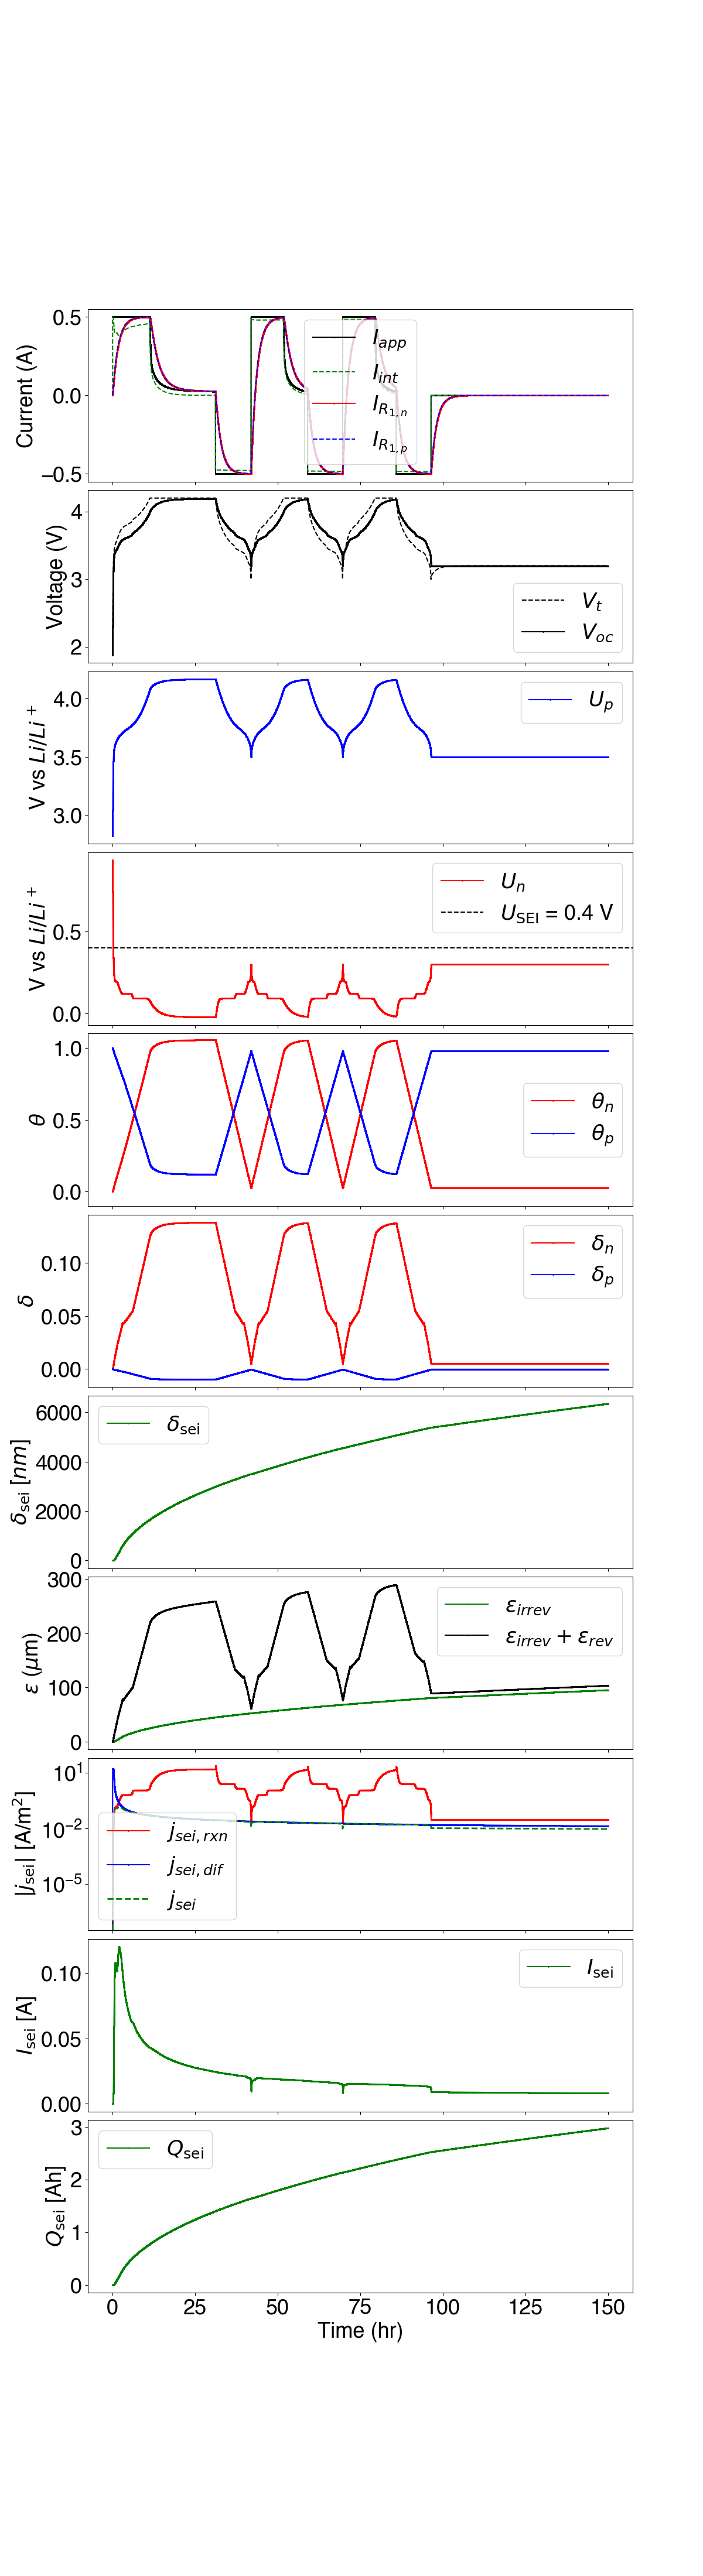

In [13]:
%autoreload
sim.plot()

In [9]:
df = pd.DataFrame(sim.__dict__)
df

,cell,dt,t,vmax,vmin,i_cv,i_app,cycle_number,step_number,theta_n,...,j_sei_rxn,j_sei_dif,j_sei,i_sei,q_sei,delta_sei,delta_n,delta_p,expansion_rev,expansion_irrev
0,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,0.0,4.2,3.0,0.025,0.5,1.0,0.0,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-09,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00
1,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,1.0,4.2,3.0,0.025,0.5,1.0,0.0,0.000000,...,8.585597e-08,17.525596,-8.585597e-08,7.211901e-08,2.003306e-11,5.000000e-09,0.000000,-0.000000e+00,0.000000e+00,7.500000e-08
2,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,2.0,4.2,3.0,0.025,0.5,1.0,0.0,0.000028,...,8.847611e-08,17.525596,-8.847611e-08,7.431993e-08,4.067749e-11,5.000000e-09,0.000006,-2.546296e-07,8.834877e-09,7.500000e-08
3,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,3.0,4.2,3.0,0.025,0.5,1.0,0.0,0.000056,...,9.117052e-08,17.525595,-9.117052e-08,7.658323e-08,6.195061e-11,5.000000e-09,0.000011,-5.092592e-07,1.766975e-08,7.500000e-08
4,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,4.0,4.2,3.0,0.025,0.5,1.0,0.0,0.000083,...,9.394111e-08,17.525595,-9.394111e-08,7.891053e-08,8.387020e-11,5.000000e-09,0.000017,-7.638888e-07,2.650463e-08,7.500000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,359995.0,4.2,3.0,0.025,0.5,4.0,0.0,0.375277,...,6.746054e-01,0.015984,-1.561404e-02,1.311579e-02,2.572989e+00,5.482242e-06,0.048764,-3.440037e-03,7.553967e-05,8.223362e-05
359996,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,359996.0,4.2,3.0,0.025,0.5,4.0,0.0,0.375304,...,6.746054e-01,0.015984,-1.561401e-02,1.311577e-02,2.572992e+00,5.482249e-06,0.048765,-3.440285e-03,7.554151e-05,8.223374e-05
359997,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,359997.0,4.2,3.0,0.025,0.5,4.0,0.0,0.375331,...,6.746054e-01,0.015984,-1.561399e-02,1.311575e-02,2.572996e+00,5.482257e-06,0.048767,-3.440533e-03,7.554335e-05,8.223386e-05
359998,<src.cellsim.Cell object at 0x10dbdcd30>,1.0,359998.0,4.2,3.0,0.025,0.5,4.0,0.0,0.375358,...,6.746054e-01,0.015984,-1.561397e-02,1.311574e-02,2.572999e+00,5.482265e-06,0.048768,-3.440781e-03,7.554519e-05,8.223397e-05


# Calculate cycle-by-cycle metrics

In [4]:
df = pd.DataFrame(sim.__dict__)
df['dq'] = np.abs(df['dt'] * df['i_app'] / 3600)
df_agg = df.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_agg

cycle_number  step_number
0.0           0.0            0.000000
1.0           0.0            5.624306
              1.0            1.057415
              2.0            5.385972
2.0           0.0            4.905139
              1.0            0.550301
              2.0            5.312222
3.0           0.0            4.865556
              1.0            0.507792
              2.0            5.277917
4.0           0.0            1.792639
Name: dq, dtype: float64

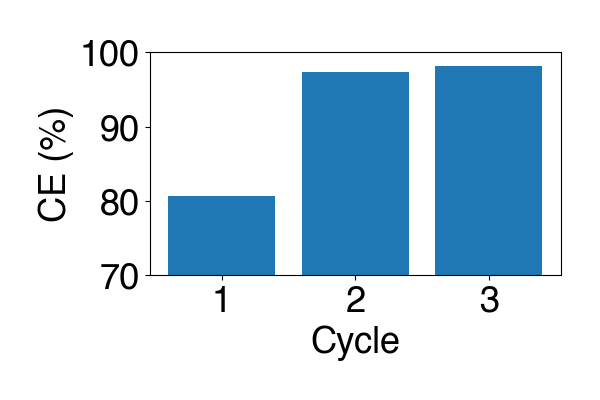

In [5]:
from matplotlib import pyplot as plt

ce = []
cycle_index = np.array([1, 2, 3])

for i in cycle_index:
    ce.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))

ce = np.array(ce)

plt.figure(figsize=(6, 4))
plt.bar(cycle_index, ce*100)
plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.ylim([70, 100])
plt.show()
